In [4]:
import numpy as np
from scipy.integrate import quad
from scipy.integrate import simpson
from scipy.special import erfinv

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

eps = 2*np.sqrt(np.finfo("float").eps)

In [5]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [6]:
def integral(y, x):
    return simpson(y, x, axis = 0)

In [7]:
def random_mat_cor(P):
    
    A = np.random.normal(size = (P, P))
    B = A @ A.T
    
    B = np.abs(B)
    D = np.diagonal(B)[np.newaxis]
    
    mat_cor = D.T**(-1/2) * B * D**(-1/2)
    
    return mat_cor

In [8]:
def random_mat_dom(P):
    
    A = np.random.normal(size = (P, P))
    B = A @ A.T
    
    B = np.abs(B)
    np.fill_diagonal(B, np.sum(B, axis = 0))
    
    D = np.diagonal(B)[np.newaxis]
    
    mat_dom = D.T**(-1/2) * B * D**(-1/2)
    
    return mat_dom

In [9]:
def simple_mat_cor(P, c):
    mat_cor = (1 - c) * np.eye(P, P) + c * np.ones((P, P))
    
    return mat_cor

In [10]:
def random_multivariate_binary(mat_cor, P, n_binary_samples):
    spins_x = np.sign(np.random.multivariate_normal(np.zeros(P), np.sin(np.pi/2 * mat_cor), n_binary_samples))
    # print(spins_x)
    # print(spins_x.reshape(1, -1, P, 1))
    
    # print(np.random.multivariate_normal(np.zeros(P), np.sin(np.pi/2 * mat_cor), n_binary_samples))
    
    return spins_x

In [681]:
class Iterator():
    def __init__(self, beta, alpha, mat_cor, P, n_normal_samples, n_binary_samples, print_comparison = False):
        self.mat_cor = mat_cor
        self.P = P
        
        spins_base = np.full((P, 2), np.array([-1, 1]))
        
        self.spins_s = np.array(np.meshgrid(*spins_base)).T.reshape(-1, 1, P, 1)
        self.spins_s_T = np.transpose(self.spins_s, axes = (0, 1, 3, 2))
        
        self.spins = self.spins_s.reshape(-1, 1, 1, P, 1)
        self.spins_T = self.spins_s_T.reshape(-1, 1, 1, 1, P)
        
        self.spins_u = self.spins_s.reshape(-1, 1, 1, 1, P, 1)
        self.spins_u_T = self.spins_s_T.reshape(-1, 1, 1, 1, 1, P)
        
        z_off_diag = np.random.normal(size = (n_normal_samples, P*(P - 1)//2))
        z_off_diag = (z_off_diag - np.flip(z_off_diag, axis = 0))/2
        
        C = np.array(np.cov(z_off_diag, rowvar = False), ndmin = 2)
        L = np.linalg.cholesky(C)
        z_off_diag = np.linalg.solve(L, z_off_diag.T).T
        
        self.z_off_diag = np.zeros((n_normal_samples, P, P))
        
        self.z_off_diag[:, np.tri(P, dtype = "bool", k = -1)] = z_off_diag
        
        self.z_off_diag = self.z_off_diag + np.transpose(self.z_off_diag, axes = (0, 2, 1))
        
        z_on_diag = np.random.normal(size = (n_normal_samples, P))
        z_on_diag = (z_on_diag - np.flip(z_on_diag, axis = 0))/2
        
        C = np.array(np.cov(z_on_diag, rowvar = False), ndmin = 2)
        L = np.linalg.cholesky(C)
        z_on_diag = np.linalg.solve(L, z_on_diag.T).T
        
        self.z_on_diag = z_on_diag[:, np.newaxis]
        
        spins_x = random_multivariate_binary(mat_cor, P, n_binary_samples).reshape(1, -1, P, 1)
        
        self.p_x = np.mean(np.all(self.spins_s == spins_x, axis = 2, keepdims = True), axis = 1, keepdims = True)
        
        self.update_params(beta, alpha)
        
        self.print_comparison = print_comparison
    
    def update_params(self, beta, alpha):
        self.beta = beta
        self.alpha = alpha
        self.H_M = self.hamiltonian(self.beta, self.mat_cor)
        self.p_M = self.probability(self.H_M)
    
    def action_eff(self, m, s, q_on_diag, q_off_diag, beta_eff):
        
        q_sym = (q_off_diag + q_off_diag.T)/2
        q_sub = q_on_diag - np.sum(q_sym, axis = 1, keepdims = True)
        
        H_re = beta_eff * ((self.spins_T * self.z_on_diag) @ np.sqrt(np.maximum(q_sub, 0))
                           + (self.spins_u_T * self.z_on_diag) @ np.sqrt(np.maximum(q_sub, 0)))
        
        H_re = H_re + beta_eff * (self.spins_T @ np.sum(self.z_off_diag * np.sqrt(np.maximum(q_sym, 0)), axis = -1, keepdims = True)
                                  + self.spins_u_T @ np.sum(self.z_off_diag * np.sqrt(np.maximum(q_sym, 0)), axis = -1, keepdims = True))
        
        H_re = H_re + 1/2*beta_eff**2 * ((self.spins_T @ (s - q_sym) @ self.spins) + 2 * (self.spins_T @ m @ self.spins_s)
                                         + (self.spins_u_T @ (s - q_sym) @ self.spins_u) + 2 * (self.spins_u_T @ m @ self.spins_s))
        
        H_im = beta_eff * ((self.spins_T * self.z_on_diag) @ np.sqrt(np.maximum(-q_sub, 0))
                           - (self.spins_u_T * self.z_on_diag) @ np.sqrt(np.maximum(-q_sub, 0)))
        
        H_im = H_im + beta_eff * (self.spins_T @ np.sum(self.z_off_diag * np.sqrt(np.maximum(-q_sym, 0)), axis = -1, keepdims = True)
                                  - self.spins_u_T @ np.sum(self.z_off_diag * np.sqrt(np.maximum(-q_sym, 0)), axis = -1, keepdims = True))
        
        C = np.max(H_re, axis = 0)
        M_L = np.sum(np.cos(H_im) * np.exp(H_re - C), axis = 0)
        H_L = C + np.log(np.abs(M_L))
        
        M_L = np.sign(M_L)
        
        return H_L, M_L
    
    def hamiltonian(self, beta_eff, mat_cor):
        return 1/2*beta_eff**2 * (self.spins_s_T @ mat_cor @ self.spins_s)
    
    def probability(self, H, M = 1):
        C = np.max(H, axis = 0)
        M = M * np.exp(H - C)
        return M / np.sum(M, axis = 0)
    
    def update(self, m, s, q):
        
        q_on_diag = np.diagonal(q).copy()[:, np.newaxis]
        q_off_diag = q - np.eye(P, P) * q_on_diag
        
        H_L, M_L = self.action_eff(m, s, q_on_diag, q_off_diag, self.beta)
        p_L = self.probability(H_L, M_L)
        
        H_q = self.hamiltonian(self.beta, s)
        p_q = self.probability(H_q)
        
        m_hat = self.beta**2*self.alpha * np.squeeze(np.sum(self.p_M * np.mean(self.spins_s * np.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s_hat = self.beta**2*self.alpha * np.squeeze(np.sum(self.p_M * np.mean(np.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0) - np.sum(p_q * self.spins_s_T * self.spins_s, axis = 0))
        q_hat = self.beta**2*self.alpha * np.squeeze(np.sum(self.p_M * np.mean(np.sum(p_L * self.spins_T, axis = 0) * np.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        # q_num = np.mean(np.sum(p_L * self.spins_T, axis = 0) * np.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True)
        # q_ana_on_diag = np.mean(np.tanh(self.beta**2 + self.beta * self.z_on_diag)**2, axis = 0, keepdims = True)
        # q_ana_off_diag = np.mean(np.tanh(self.beta**2 + self.beta * self.z_on_diag), axis = 0, keepdims = True)**2
        
        # q_ana = q_ana_on_diag * np.eye(P, P) + q_ana_off_diag * (np.ones((P, P)) - np.eye(P, P))
        # q_ana = self.spins_s_T * self.spins_s * q_ana
        
        # q_max = np.max(q)
        
        # print("Intermediate numerical result:")
        # print(q_num)
        # print("Intermediate analytical result:")
        # print(q_ana)
        
        # print("Final numerical result:")
        # print(np.sum(self.p_M * q_num, axis = 0))
        # print("Final analytical result:")
        # print(np.sum(self.p_M * q_ana, axis = 0))
        
        if self.print_comparison:
        
            print("Numerical m_hat:")
            print(m_hat)
            print("Numerical s_hat:")
            print(s_hat)
            print("Numerical q_hat:")
            print(q_hat)
            
            m_max = np.max(m)
            m_test = self.beta**2 * self.alpha * np.mean(np.tanh(self.beta**2 * m_max + self.beta * self.z_on_diag * np.sqrt(m_max)))
            
            q_max = np.max(q)
            q_test = self.beta**2 * self.alpha * np.mean(np.tanh(self.beta**2 * q_max + self.beta * self.z_on_diag * np.sqrt(q_max))**2)
            
            print("Analytical m_hat:")
            print(m_test)
            print("Analytical q_hat:")
            print(q_test)
            
        q_hat_on_diag = np.diagonal(q_hat).copy()[:, np.newaxis]
        q_hat_off_diag = q_hat - np.eye(P, P) * q_hat_on_diag
        
        H_L, M_L = self.action_eff(m_hat, s_hat, q_hat_on_diag, q_hat_off_diag, 1)
        p_L = self.probability(H_L, M_L)
        
        m = np.squeeze(np.sum(self.p_x * np.mean(self.spins_s * np.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s = np.squeeze(np.sum(self.p_x * np.mean(np.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        q = np.squeeze(np.sum(self.p_x * np.mean(np.sum(p_L * self.spins_T, axis = 0) * np.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        if self.print_comparison:
            
            print("Numerical m:")
            print(m)
            print("Numerical s:")
            print(s)
            print("Numerical q:")
            print(q)
            
            m_max = np.max(m_hat)
            m_test = np.mean(np.tanh(m_max + self.z_on_diag * np.sqrt(m_max)))
            
            q_max = np.max(q_hat)
            q_test = np.mean(np.tanh(q_max + self.z_on_diag * np.sqrt(q_max))**2)
            
            print("Analytical m:")
            print(m_test)
            print("Analytical q:")
            print(q_test)
        
        return m, s, q
    
    def iterate(self, m, s, q, t, store_state):
        
        m_list = []
        s_list = []
        q_list = []
        
        for _ in range(t):
            if store_state:
                m_list.append(m)
                s_list.append(s)
                q_list.append(q)
            
            m, s, q = self.update(m, s, q)
        
        m_list.append(m)
        s_list.append(s)
        q_list.append(q)
        
        return m_list, s_list, q_list # m, s, q

In [684]:
n_normal_samples = 200000
n_binary_samples = 2000000

beta = 1.2
alpha = 1.4
P = 2
c = 0

mat_cor = simple_mat_cor(P, c)

print_comparison = True

iterator = Iterator(beta, alpha, mat_cor, P, n_normal_samples, n_binary_samples, print_comparison)

Numerical m_hat:
[[0.98825073 0.90103999]
 [0.90100248 0.98824425]]
Numerical s_hat:
[[ 0.       -0.423117]
 [-0.423117  0.      ]]
Numerical q_hat:
[[1.38373109 1.37577396]
 [1.37577396 1.38396564]]
Analytical m_hat:
1.3451714028883506
Analytical q_hat:
1.3457382128051505
Numerical m:
[[0.28559343 0.13937043]
 [0.13954529 0.28541463]]
Numerical s:
[[ 1.         -0.42390243]
 [-0.42390243  1.        ]]
Numerical q:
[[0.19391901 0.15352864]
 [0.15352864 0.19399889]]
Analytical m:
0.5466638680209509
Analytical q:
0.6548169595619115
Numerical m_hat:
[[ 0.53173907 -0.06250303]
 [-0.06253979  0.53130705]]
Numerical s_hat:
[[0.         0.09833424]
 [0.09833424 0.        ]]
Numerical q_hat:
[[ 0.3195964  -0.06355033]
 [-0.06355033  0.32002968]]
Analytical m_hat:
0.6108255352174425
Analytical q_hat:
0.4506898329042882
Numerical m:
[[0.39864244 0.00119793]
 [0.00117111 0.39843044]]
Numerical s:
[[1.         0.08139973]
 [0.08139973 1.        ]]
Numerical q:
[[0.35928072 0.04471462]
 [0.04471462

Numerical m_hat:
[[ 0.25429259 -0.26092173]
 [-0.25913823  0.26464364]]
Numerical s_hat:
[[-4.47641924e-16  3.62314616e-01]
 [ 3.62314616e-01 -4.47641924e-16]]
Numerical q_hat:
[[ 1.82370972 -0.59174973]
 [-0.59174973  1.52246273]]
Analytical m_hat:
0.29811921030250577
Analytical q_hat:
0.8537404491417224
Numerical m:
[[ 0.06034991 -0.06516275]
 [-0.0619735   0.06877034]]
Numerical s:
[[1.         0.62114689]
 [0.62114689 1.        ]]
Numerical q:
[[1.88538402 0.79396722]
 [0.79396722 1.91777784]]
Analytical m:
0.21386417971686358
Analytical q:
0.7414860348507606
Numerical m_hat:
[[ 0.08562927 -0.08675433]
 [-0.09273384  0.09604286]]
Numerical s_hat:
[[ 0.         -1.35431991]
 [-1.35431991  0.        ]]
Numerical q_hat:
[[1.13033842 0.18025461]
 [0.18025461 1.13845679]]
Analytical m_hat:
0.1825004860881756
Analytical q_hat:
1.7260085169615438
Numerical m:
[[ 0.08177832 -0.08263026]
 [-0.08369323  0.08482819]]
Numerical s:
[[ 1.         -0.84178268]
 [-0.84178268  1.        ]]
Numerica

Numerical m_hat:
[[ 0.01372443 -0.02353688]
 [-0.01077288  0.01953727]]
Numerical s_hat:
[[0.         0.18480028]
 [0.18480028 0.        ]]
Numerical q_hat:
[[4.65926799 1.03371296]
 [1.03371296 4.99130127]]
Analytical m_hat:
0.08281873785574627
Analytical q_hat:
1.991835805575749
Numerical m:
[[ 0.00577948 -0.00492822]
 [-0.01000512  0.00880132]]
Numerical s:
[[ 1.         -0.33408373]
 [-0.33408373  1.        ]]
Numerical q:
[[ 0.65415689 -0.23885833]
 [-0.23885833  0.66443059]]
Analytical m:
0.01916738936135185
Analytical q:
0.9612093818920158
Numerical m_hat:
[[ 0.01130269 -0.0191934 ]
 [-0.00973744  0.0169358 ]]
Numerical s_hat:
[[4.47641924e-16 4.23366970e-01]
 [4.23366970e-01 4.47641924e-16]]
Numerical q_hat:
[[ 1.36763582 -0.1453951 ]
 [-0.1453951   1.33443496]]
Analytical m_hat:
0.02523337119597942
Analytical q_hat:
1.0818601641976209
Numerical m:
[[ 0.00501488 -0.00335761]
 [-0.00820631  0.00558726]]
Numerical s:
[[1.        0.3949825]
 [0.3949825 1.       ]]
Numerical q:
[[0

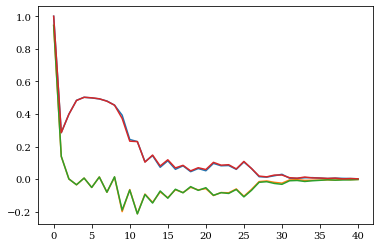

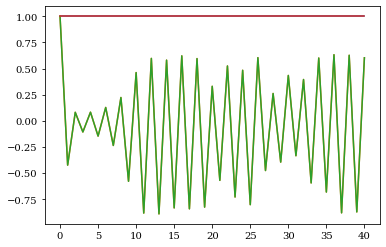

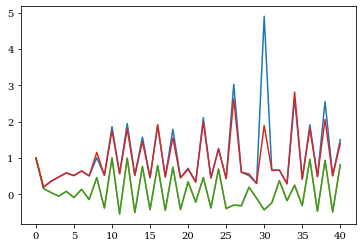

In [687]:
# Probe c = 0.1, 0.4, 0.7, 1
# or c = 0.1, 0.25, 0.4, 0.55, 0.7, 0.85, 1

t = 40

m = random_mat_cor(P)
s = random_mat_cor(P)
q = random_mat_cor(P)

m_list, s_list, q_list = iterator.iterate(m, s, q, t, store_state = True)

plt.plot(np.array(m_list).reshape(t+1, P**2))
plt.show()

plt.plot(np.array(s_list).reshape(t+1, P**2))
plt.show()

plt.plot(np.array(q_list).reshape(t+1, P**2))
plt.show()

In [ ]:
n_normal_samples = 200000
n_binary_samples = 2000000
t = 20

n_alpha = 20

q_comp_range = np.zeros(n_alpha)
q_simp_range = np.zeros(n_alpha)

beta = 1.2
alpha = 0
P = 2
c = 0

mat_cor = simple_mat_cor(P, c)

iterator = Iterator(beta, alpha, mat_cor, P, n_normal_samples, n_binary_samples)

alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

m_init = np.identity(P) # random_mat_cor(P)
s_init = np.identity(P) # random_mat_cor(P)
q_init = np.identity(P) # random_mat_cor(P)

for j, alpha in enumerate(alpha_range):
    iterator.update_params(beta, alpha)
    m, s, q = iterator.iterate(m_init, s_init, q_init, t, store_state = False)
    q_comp_range[j] = np.max(m)
    
    
    
    q_simp_range[j]

fontsize = 13

plt.imshow(q_range, aspect = 2, origin = "lower", cmap = "viridis",
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)))
plt.plot(T_range**4/eigval_range, T_range, color = "black")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar(ticks = [0, 1/2])
colorbar.ax.set_yticklabels([0, 1/2], fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"$\alpha$", fontsize = fontsize)
plt.ylabel(r"$T$", fontsize = fontsize)
plt.show()

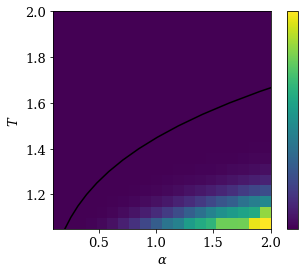

In [60]:
n_normal_samples = 20000
n_binary_samples = 200000
t = 10

n_beta = 20
n_alpha = 20

q_range = np.zeros((n_beta, n_alpha))
eigval_range = np.zeros(n_beta)

beta = 0
alpha = 0
P = 2
c = 0.7

mat_cor = simple_mat_cor(P, c)

iterator = Iterator(beta, alpha, mat_cor, P, n_normal_samples, n_binary_samples)

T_range = np.linspace(1.05, 2, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

m_init = random_mat_cor(P)
s_init = random_mat_cor(P)
q_init = random_mat_cor(P)

for i, T in enumerate(T_range):
    for j, alpha in enumerate(alpha_range):
        iterator.update_params(1/T, alpha)
        m, s, q = iterator.iterate(m_init, s_init, q_init, t, store_state = False)
        q_range[i, j] = np.mean(m)
    
    d = np.squeeze(np.sum(iterator.p_M * iterator.spins_s_T * iterator.spins_s, axis = 0))[0, 1]
    eigval = (P - 1)**2 * c*d + (P - 1) * (c + d) + 1
    eigval_range[i] = eigval

fontsize = 13

plt.imshow(q_range, aspect = 2, origin = "lower", cmap = "viridis",
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)))
plt.plot(T_range**4/eigval_range, T_range, color = "black")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar(ticks = [0, 1/2])
colorbar.ax.set_yticklabels([0, 1/2], fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"$\alpha$", fontsize = fontsize)
plt.ylabel(r"$T$", fontsize = fontsize)
plt.show()

# $S = \beta^4 \alpha Q R$
# $\alpha_{\text{crit}} \leq \frac{1}{\beta^4 \lambda^S_{\text{max}}}$

### Plot unrelated probability distributions

In [12]:
def prob(x, p):
    return np.exp(-x**p)

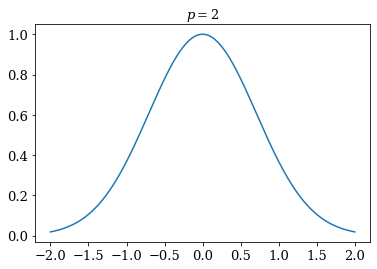

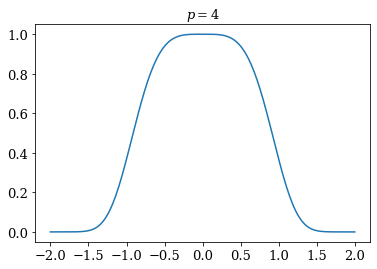

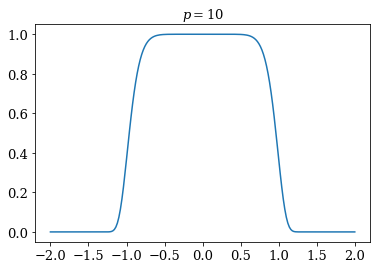

In [24]:
fontsize = 13

x = np.linspace(-2, 2, num = 201, endpoint = True)
p_range = np.array([2, 4, 10])

for p in p_range:
    plt.plot(x, prob(x, p))
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.title(r"$p = %d$" % p, fontsize = fontsize)
    plt.show()